In [1]:
from chainer import Link, Chain, ChainList, Variable, optimizers, iterators
import chainer.functions as F
import chainer.links as L
from chainer import cuda
from chainer import initializers
from chainer import serializers

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# GPU settings
gpu_index = 0
if gpu_index >= 0:
    cuda.check_cuda_available()
xp = cuda.cupy if gpu_index >= 0 else np

# 車輪型ロボットモデル（対向2輪型）

In [3]:
class CartLayer:
    def __init__(self,batchsize=1):
        self.cart_num = batchsize
        self.pos = Variable(np.zeros( (batchsize,3), dtype=np.float32))
        self.path = np.zeros( (1,batchsize,3),dtype=float)

    def move(self,param):
        if len(param) == self.cart_num:
            dx = F.reshape(param[:,0] * F.cos(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dy = F.reshape(param[:,0] * F.sin(self.pos[:,2] + param[:,1]), (self.cart_num,1))
            dth = F.reshape(param[:,1], (self.cart_num,1))
            D = F.concat((dx,dy),axis=1)
            D = F.concat((D,dth),axis=1)
            self.pos = self.pos + D
            self.path = np.vstack([self.path,[self.pos.data]])
            return self.pos
        else:
            print 'len(param) != cart_num'
            return -1

# 連続で動く
def calc_car_pos(cart_layer, y):
    for step in range(len(y[0])):
        cart_layer.move(y[:,step])
    # print car.path.shape  # (4step, 50batch, 3x-y-th)
    # print car.pos.data.shape  # (50batch, 3x-y-th)
    return cart_layer.pos

# 経路の描画

In [4]:
def plot_path(cart_path,target):
    path = cart_path[:,0,:]
    for i in range(1,len(path)):
        plt.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   ,scale_units='xy', angles='xy', scale=1,color="blue")
    plt.scatter(target[0],target[1],c="yellow",s=500,marker="*")
    plt.xlabel("x")
    plt.ylabel("y")
    #plt.axis('scaled')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.grid()
    plt.show()

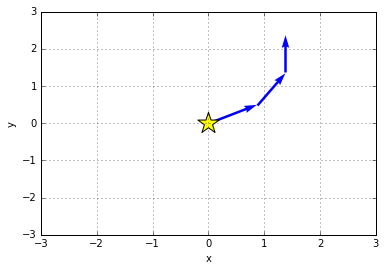

[[[0.         0.         0.        ]]

 [[0.86602539 0.5        0.52359879]]

 [[1.36602533 1.36602545 1.04719758]]

 [[1.36602533 2.36602545 1.57079637]]]


''

In [5]:
''' sample '''
v_arr = np.array([1.0,1.0,1.0],dtype=np.float32)
w_arr = np.array([30.0,30.0,30.0],dtype=np.float32)
w_arr = w_arr * np.pi/180
y_data = np.vstack((v_arr,w_arr)).T
yV = Variable(np.reshape(y_data,(1,3,2) )) 

sample_cart = CartLayer()
pos = calc_car_pos(sample_cart,yV)
plot_path(sample_cart.path,[0,0])
print sample_cart.path
''''''

# ネットワーク

In [6]:
class Generator(Chain):
    def __init__(self):
        initializer = initializers.HeNormal()
        super(Generator, self).__init__(
            l1=L.Linear(2, 15, initialW=initializer),
            l2=L.Linear(15, 8, initialW=initializer),
            l3=L.Linear(8, 6, initialW=initializer),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        h3 = self.l3(h2)
        h4 = F.tanh(h3)
        o = F.reshape(h4,(len(x),3,2))
        return o
    '''
    def get_vw(self,output):
        v = output[0,0:3]
        w = output[0,3:6]
        return v,w
    '''

**入出力を確認**

In [7]:
''' sample '''
sample_model = Generator()
sample_x_data = np.array([[3,0]],dtype=np.float32)
sample_x = Variable(sample_x_data)
print sample_x_data
sample_y = sample_model(sample_x_data)
print sample_y
''' '''

[[3. 0.]]
variable([[[-0.9296355  -0.96000177]
           [ 0.9652878   0.50551873]
           [ 0.36563477  1.        ]]])


' '

### 2018/10/24　オフィスアワー

---
問題点  
* **（0,0）で動かなければ損失が少ないと学習してしまう**  
    ・極座標系で距離を一定に学習する
    
    
* **optimizers.update() **  
    ・勾配を手動計算する場合は引数不要・勾配リセットも必要  
    ・そうでない場合はloss_functionを引数に渡す

その他  
* **Variable配列の型が違って気持ち悪いので行列演算にしたい**

# 極座標変換

[1, 1]
[1.4142135623730951, 45.0]


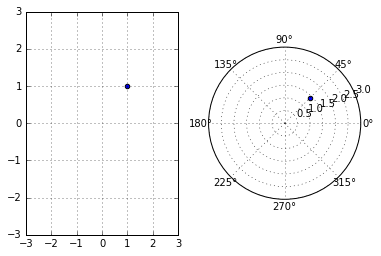

In [8]:
# 極座標変換
def to_polar_coordinate(x,y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x)
    return r,theta
# 直交座標変換
def to_cartesian_coordinate(r,theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x,y

sample_x,sample_y = [1,1]
sample_r,sample_theta = to_polar_coordinate(sample_x,sample_y)
print [sample_x,sample_y]
print [sample_r, sample_theta*180/np.pi]
# 直交系グラフ
ax1 = plt.subplot(1,2,1)
ax1.scatter(sample_x,sample_y)
ax1.axis([-3,3,-3,3])
ax1.grid(True)

# 極座標系グラフ
ax2 = plt.subplot(1,2,2,polar=True)
ax2.scatter(sample_theta,sample_r)
ax2.set_rmax(3)
ax2.grid(True)


# 訓練データの作成

* 極座標系で角度をランダムに指定  

\begin{equation*}
\begin{bmatrix}
r = 2 \\
-\frac{π}{2} < θ < \frac{π}{2}
\end{bmatrix}
\end{equation*}

DATA_SHAPE(1000, 2)


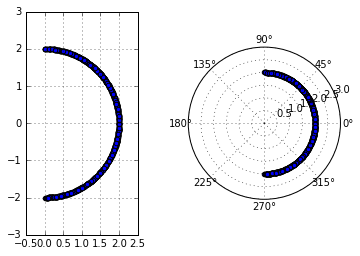

In [37]:
def random_point(size):
    r = np.full(size, 2)
    theta = np.random.rand(size) * np.pi - (np.pi/2)
    return r, theta

def generate_dataset(r,theta,plot=0):
    x,y = to_cartesian_coordinate(r,theta)
    x_data = np.vstack([x,y])
    x_data = x_data.T
    x_data = np.array(x_data, dtype=np.float32)
    print 'DATA_SHAPE{}'.format(x_data.shape)
    if (plot>0) :
        fig1 = plt.subplot(1,2,2,polar=True)
        fig1.scatter(theta,r)
        fig1.set_rmax(3)
        fig1.grid(True)

        fig2 = plt.subplot(1,2,1)
        fig2.scatter(x,y)
        fig2.axis([-3,3,0,3])
        plt.axis('scaled')
        fig2.grid(True)
    return x_data
r, theta = random_point(1000)
x_data = generate_dataset(r,theta,plot=1)
# print x_data

# 損失関数

In [50]:
def calc_distance(predpos,truepos):
    px, py, _ = predpos
    tx, ty = truepos
    D = F.sqrt( (tx-px)**2 + (ty-py)**2 )
    # print "p:{},{} t:{},{}  = D:{}".format(px,py,tx,ty,D)
    return D

sample_p = Variable(np.array([-0.04729605 , 3.132064, 0], dtype=np.float32))
sample_t = Variable(np.array([-0.9656074  ,1.9671886], dtype=np.float32))
print calc_distance(sample_p,sample_t)
# 1.4833174

def velo_diff(v):
    # v (batch,3)
    V = np.zeros(len(v),dtype=np.float32)
    for i in range(len(v[0])-1):
        diff = v[:,i] - v[:,i+1]
        V = V + diff*diff
    init_pos = np.zeros(len(v),dtype=np.float32)
    diff = init_pos - v[:,0]
    V = V + diff*diff
    return V
    
def loss_function(y, predpos, truepos):
    ppos = F.reshape(predpos, (3,len(predpos))) #(batch,3) -> (3,batch)
    tpos = F.reshape(truepos, (2,len(truepos))) #(2,batch)
    D = calc_distance(ppos, tpos)
    v = y[:,:,0]
    w = y[:,:,1]
    V = velo_diff(v)
    W = velo_diff(w)
    E = (100*D) + V + W
    loss = F.mean(E)
    return loss

variable(1.4833174)


# 訓練

In [11]:
def train(x_data):
    batch_size = 1
    model = Generator()
    opt = optimizers.Adam()
    gpu_id = -1
    if gpu_id >= 0:
        model.to_gpu(gpu_id)
    train_iter = iterators.SerialIterator(x_data, batch_size)
    opt.setup(model)
    max_epoch = 10
    snapshot = 5
    epoch = 0
    while train_iter.epoch < max_epoch:
        train_batch = np.array(train_iter.next())
        
        x = Variable(train_batch.astype(np.float32).reshape(len(train_batch),2))
        y = model(x)
        truepos = Variable(train_batch.astype(np.float32).reshape(len(train_batch),2))
        car = CartLayer(len(y))
        predpos = calc_car_pos(car, y)
        loss = loss_function(y,predpos,truepos)
        model.cleargrads()
        loss.backward()
        opt.update(loss_function,y,predpos,truepos)
        epoch = epoch + 1
        if (epoch % snapshot)==0:
            print str(epoch)+": loss "+str(loss.data)
            # print model.l1.W.grad
            # plot_path(car.path, target_pos.data)
    return model
model = train(x_data)

5: loss 307.28238
10: loss 348.12244
15: loss 311.09525
20: loss 201.65182
25: loss 324.34106
30: loss 192.70215
35: loss 282.09946
40: loss 286.80795
45: loss 185.0437
50: loss 167.7606
55: loss 263.06567
60: loss 252.81987
65: loss 124.48418
70: loss 112.80831
75: loss 230.63696
80: loss 165.45859
85: loss 142.76843
90: loss 196.33817
95: loss 101.31581
100: loss 221.08653
105: loss 160.84012
110: loss 152.20186
115: loss 178.04704
120: loss 179.49374
125: loss 109.76591
130: loss 159.90717
135: loss 65.860756
140: loss 157.66347
145: loss 63.893585
150: loss 57.41328
155: loss 99.80363
160: loss 47.5617
165: loss 63.273987
170: loss 61.196735
175: loss 61.694378
180: loss 60.08561
185: loss 36.7161
190: loss 75.270615
195: loss 60.186546
200: loss 53.397457
205: loss 59.782757
210: loss 15.063871
215: loss 50.210835
220: loss 46.524876
225: loss 45.08286
230: loss 73.63052
235: loss 102.162766
240: loss 96.235374
245: loss 44.829823
250: loss 66.02575
255: loss 23.966038
260: loss 2

2060: loss 29.51126
2065: loss 10.210359
2070: loss 16.52289
2075: loss 4.778604
2080: loss 26.685871
2085: loss 19.984735
2090: loss 3.8037174
2095: loss 4.1591735
2100: loss 21.842009
2105: loss 7.563792
2110: loss 6.2780895
2115: loss 22.684198
2120: loss 22.470963
2125: loss 37.625248
2130: loss 6.5863056
2135: loss 4.718808
2140: loss 20.456923
2145: loss 41.25742
2150: loss 19.915956
2155: loss 39.192513
2160: loss 6.2814794
2165: loss 19.453434
2170: loss 10.503465
2175: loss 14.95425
2180: loss 4.7217565
2185: loss 43.841866
2190: loss 39.90582
2195: loss 6.2657847
2200: loss 5.651046
2205: loss 23.99629
2210: loss 17.48676
2215: loss 40.016914
2220: loss 11.635303
2225: loss 8.085077
2230: loss 17.85898
2235: loss 8.872998
2240: loss 28.45462
2245: loss 14.284818
2250: loss 36.375854
2255: loss 5.054376
2260: loss 17.752436
2265: loss 9.594768
2270: loss 21.243284
2275: loss 17.364605
2280: loss 10.074448
2285: loss 3.957721
2290: loss 6.231329
2295: loss 7.435007
2300: loss 5

4050: loss 9.528123
4055: loss 3.1392593
4060: loss 17.948532
4065: loss 24.998753
4070: loss 5.216652
4075: loss 22.073402
4080: loss 2.5259073
4085: loss 8.656059
4090: loss 2.5718255
4095: loss 3.5835319
4100: loss 17.185167
4105: loss 4.5283623
4110: loss 20.582174
4115: loss 5.602664
4120: loss 29.349522
4125: loss 6.6421776
4130: loss 18.616093
4135: loss 4.790414
4140: loss 6.9912896
4145: loss 2.5842001
4150: loss 17.81628
4155: loss 5.5510244
4160: loss 16.498188
4165: loss 10.909932
4170: loss 13.72104
4175: loss 13.921307
4180: loss 39.73162
4185: loss 2.6013055
4190: loss 14.846456
4195: loss 30.770672
4200: loss 39.789883
4205: loss 8.491999
4210: loss 4.444489
4215: loss 31.537077
4220: loss 19.984367
4225: loss 5.8150268
4230: loss 4.192056
4235: loss 16.7198
4240: loss 30.150188
4245: loss 9.295711
4250: loss 14.049903
4255: loss 8.915564
4260: loss 3.5082855
4265: loss 7.712072
4270: loss 4.409109
4275: loss 20.656858
4280: loss 7.2650466
4285: loss 32.6871
4290: loss 

6040: loss 20.70719
6045: loss 14.971547
6050: loss 22.50624
6055: loss 9.241096
6060: loss 5.7138686
6065: loss 5.038888
6070: loss 9.049729
6075: loss 6.7913933
6080: loss 15.398771
6085: loss 36.698063
6090: loss 39.448845
6095: loss 4.746326
6100: loss 16.313047
6105: loss 2.9616072
6110: loss 2.3443434
6115: loss 15.511068
6120: loss 3.2104218
6125: loss 36.759636
6130: loss 3.0227988
6135: loss 3.8124177
6140: loss 4.346757
6145: loss 3.266593
6150: loss 21.611128
6155: loss 5.418699
6160: loss 4.9116383
6165: loss 7.274952
6170: loss 7.780059
6175: loss 4.391516
6180: loss 2.8087974
6185: loss 4.986191
6190: loss 20.410486
6195: loss 13.652008
6200: loss 15.023805
6205: loss 6.5906405
6210: loss 9.6532755
6215: loss 2.0178354
6220: loss 3.4385502
6225: loss 10.270532
6230: loss 7.191235
6235: loss 9.993587
6240: loss 2.7145844
6245: loss 2.2868233
6250: loss 19.033222
6255: loss 3.147593
6260: loss 9.219561
6265: loss 20.396275
6270: loss 4.389085
6275: loss 4.85639
6280: loss 4

8030: loss 29.235708
8035: loss 15.125835
8040: loss 15.910901
8045: loss 3.393992
8050: loss 3.5059612
8055: loss 17.894226
8060: loss 5.478301
8065: loss 39.812073
8070: loss 4.0150776
8075: loss 9.693259
8080: loss 14.41494
8085: loss 6.018895
8090: loss 6.132776
8095: loss 4.713897
8100: loss 10.843147
8105: loss 39.22968
8110: loss 4.1261187
8115: loss 24.897472
8120: loss 14.040968
8125: loss 3.6544366
8130: loss 5.561602
8135: loss 3.349229
8140: loss 27.922268
8145: loss 5.081163
8150: loss 37.70073
8155: loss 6.7665963
8160: loss 1.9856267
8165: loss 14.612311
8170: loss 3.735198
8175: loss 4.6739416
8180: loss 4.392312
8185: loss 2.4400332
8190: loss 1.7029095
8195: loss 4.344116
8200: loss 3.536867
8205: loss 4.3734474
8210: loss 2.2822866
8215: loss 4.585134
8220: loss 28.23763
8225: loss 21.577263
8230: loss 6.2470994
8235: loss 2.498601
8240: loss 2.177726
8245: loss 4.0648713
8250: loss 3.4565113
8255: loss 3.3903859
8260: loss 13.553736
8265: loss 6.349482
8270: loss 7.

10020: loss 2.7206874
10025: loss 21.95757
10030: loss 2.9273396
10035: loss 5.4656773
10040: loss 6.562994
10045: loss 11.057783
10050: loss 6.332897
10055: loss 8.89061
10060: loss 2.8881645
10065: loss 3.3120518
10070: loss 5.6237087
10075: loss 5.7656884
10080: loss 6.2260365
10085: loss 1.9114552
10090: loss 3.634535
10095: loss 5.2982917
10100: loss 39.596123
10105: loss 19.169052
10110: loss 37.55834
10115: loss 7.985199
10120: loss 2.661376
10125: loss 3.6820383
10130: loss 26.897642
10135: loss 2.136794
10140: loss 21.832815
10145: loss 4.9664774
10150: loss 4.3035755
10155: loss 28.57202
10160: loss 4.7897377
10165: loss 4.925186
10170: loss 6.969837
10175: loss 20.443878
10180: loss 15.034744
10185: loss 36.961937
10190: loss 5.096036
10195: loss 5.8283744
10200: loss 9.407651
10205: loss 14.377242
10210: loss 14.393103
10215: loss 6.291536
10220: loss 15.327803
10225: loss 6.8911138
10230: loss 14.629545
10235: loss 28.778873
10240: loss 3.0442924
10245: loss 7.300247
10250

11915: loss 4.844124
11920: loss 16.260563
11925: loss 10.711405
11930: loss 3.2575867
11935: loss 5.072266
11940: loss 4.3213825
11945: loss 2.6517098
11950: loss 4.778758
11955: loss 4.606177
11960: loss 2.5478725
11965: loss 4.7275634
11970: loss 2.868259
11975: loss 2.2493367
11980: loss 7.4370403
11985: loss 8.624349
11990: loss 10.686645
11995: loss 32.79376
12000: loss 39.578022
12005: loss 6.4446826
12010: loss 11.529697
12015: loss 6.163452
12020: loss 2.574997
12025: loss 16.768421
12030: loss 4.848437
12035: loss 5.290857
12040: loss 5.0701623
12045: loss 5.103374
12050: loss 5.683325
12055: loss 6.526114
12060: loss 29.06495
12065: loss 33.79512
12070: loss 4.2358217
12075: loss 28.335567
12080: loss 2.5839005
12085: loss 27.087658
12090: loss 2.5973058
12095: loss 15.162121
12100: loss 5.7238693
12105: loss 37.837273
12110: loss 25.678055
12115: loss 3.4896665
12120: loss 2.4435458
12125: loss 4.995162
12130: loss 2.8531742
12135: loss 21.79066
12140: loss 2.8996353
12145:

13815: loss 6.4308195
13820: loss 4.326969
13825: loss 4.570893
13830: loss 7.806241
13835: loss 21.345577
13840: loss 5.811578
13845: loss 3.9324899
13850: loss 14.814615
13855: loss 5.9173746
13860: loss 28.714462
13865: loss 4.8628025
13870: loss 4.4538765
13875: loss 15.178169
13880: loss 4.6185484
13885: loss 3.998959
13890: loss 6.5452805
13895: loss 14.483354
13900: loss 5.4740133
13905: loss 6.684381
13910: loss 6.160698
13915: loss 24.546661
13920: loss 6.4919715
13925: loss 4.352626
13930: loss 3.0110495
13935: loss 6.5010214
13940: loss 11.355876
13945: loss 3.8013973
13950: loss 16.57934
13955: loss 14.768679
13960: loss 4.5881557
13965: loss 5.2557435
13970: loss 2.9198813
13975: loss 29.299097
13980: loss 4.392382
13985: loss 7.1060495
13990: loss 4.5855117
13995: loss 8.167489
14000: loss 6.690478
14005: loss 7.332223
14010: loss 3.8418238
14015: loss 5.175916
14020: loss 5.0952063
14025: loss 6.075856
14030: loss 31.601597
14035: loss 2.2530258
14040: loss 2.7597172
140

15715: loss 9.539007
15720: loss 21.542141
15725: loss 11.22043
15730: loss 5.8143983
15735: loss 30.117336
15740: loss 5.2855954
15745: loss 16.138203
15750: loss 39.446808
15755: loss 16.594307
15760: loss 5.968047
15765: loss 6.1595764
15770: loss 4.320633
15775: loss 37.122482
15780: loss 37.729053
15785: loss 35.16076
15790: loss 8.449073
15795: loss 3.4574738
15800: loss 1.9228817
15805: loss 31.612904
15810: loss 2.5068288
15815: loss 3.7810168
15820: loss 5.784829
15825: loss 5.419877
15830: loss 39.403675
15835: loss 5.5641837
15840: loss 13.714812
15845: loss 4.387466
15850: loss 4.0683565
15855: loss 3.1134415
15860: loss 4.278002
15865: loss 2.0085588
15870: loss 19.015125
15875: loss 1.5391105
15880: loss 3.951723
15885: loss 4.5550265
15890: loss 3.877532
15895: loss 6.03545
15900: loss 13.589468
15905: loss 3.6937156
15910: loss 2.4539614
15915: loss 4.526328
15920: loss 13.807369
15925: loss 5.9021
15930: loss 5.0696654
15935: loss 2.1492367
15940: loss 5.2427573
15945:

17620: loss 4.7049403
17625: loss 2.0357852
17630: loss 7.0557504
17635: loss 5.053896
17640: loss 6.1560364
17645: loss 6.520396
17650: loss 15.429649
17655: loss 6.686463
17660: loss 5.2655888
17665: loss 4.200695
17670: loss 39.533825
17675: loss 2.8741555
17680: loss 3.4299989
17685: loss 2.4829628
17690: loss 3.4975302
17695: loss 5.381525
17700: loss 39.84319
17705: loss 3.6524928
17710: loss 7.496011
17715: loss 36.15041
17720: loss 12.630661
17725: loss 6.0262375
17730: loss 3.7881808
17735: loss 2.4754171
17740: loss 3.1910005
17745: loss 6.1916275
17750: loss 5.4997387
17755: loss 7.537842
17760: loss 2.0463214
17765: loss 3.398032
17770: loss 3.1237116
17775: loss 14.051611
17780: loss 2.7322702
17785: loss 29.828186
17790: loss 2.9636183
17795: loss 3.0513732
17800: loss 2.5393639
17805: loss 37.939716
17810: loss 2.4557528
17815: loss 15.780403
17820: loss 2.6823392
17825: loss 22.689615
17830: loss 2.8573182
17835: loss 5.6446166
17840: loss 5.3305225
17845: loss 5.058587

19525: loss 29.168545
19530: loss 3.9952629
19535: loss 5.724795
19540: loss 7.483663
19545: loss 35.344822
19550: loss 5.2601495
19555: loss 13.623238
19560: loss 4.3283815
19565: loss 36.86922
19570: loss 3.0623217
19575: loss 14.511675
19580: loss 4.668494
19585: loss 2.1504946
19590: loss 2.867667
19595: loss 3.690398
19600: loss 4.7286124
19605: loss 14.653288
19610: loss 4.567717
19615: loss 17.504602
19620: loss 7.4249043
19625: loss 3.9511595
19630: loss 1.8549123
19635: loss 4.3686695
19640: loss 29.48379
19645: loss 29.33458
19650: loss 2.787983
19655: loss 13.772489
19660: loss 2.1475434
19665: loss 5.811404
19670: loss 3.9519613
19675: loss 14.95837
19680: loss 9.099569
19685: loss 3.9935956
19690: loss 34.379734
19695: loss 7.955203
19700: loss 1.879091
19705: loss 3.0443792
19710: loss 17.287872
19715: loss 3.2827575
19720: loss 30.46754
19725: loss 5.508477
19730: loss 5.272631
19735: loss 3.2950482
19740: loss 2.8304222
19745: loss 5.566351
19750: loss 3.9646454
19755: 

21425: loss 39.17201
21430: loss 3.0517817
21435: loss 2.7862236
21440: loss 3.3505661
21445: loss 2.542278
21450: loss 3.927682
21455: loss 3.1130977
21460: loss 39.42537
21465: loss 3.7921312
21470: loss 4.060361
21475: loss 5.869163
21480: loss 6.2042756
21485: loss 15.319231
21490: loss 5.5015736
21495: loss 3.3477871
21500: loss 5.6494
21505: loss 3.9908175
21510: loss 3.9058244
21515: loss 9.208679
21520: loss 35.11038
21525: loss 2.3281121
21530: loss 4.45123
21535: loss 4.8728213
21540: loss 3.1809857
21545: loss 5.380124
21550: loss 3.0301394
21555: loss 2.689373
21560: loss 3.0572736
21565: loss 3.2556677
21570: loss 36.701202
21575: loss 2.7768395
21580: loss 34.62188
21585: loss 14.734936
21590: loss 13.808374
21595: loss 3.5752423
21600: loss 15.629968
21605: loss 3.5265965
21610: loss 4.31709
21615: loss 2.9191802
21620: loss 13.981144
21625: loss 35.225853
21630: loss 41.449173
21635: loss 5.8282237
21640: loss 10.28443
21645: loss 25.90586
21650: loss 32.243958
21655: l

23325: loss 2.8927903
23330: loss 8.242915
23335: loss 7.8341646
23340: loss 7.4751496
23345: loss 3.4446301
23350: loss 3.7631474
23355: loss 3.5951824
23360: loss 5.92086
23365: loss 3.0354314
23370: loss 2.2073085
23375: loss 7.7633195
23380: loss 9.7383375
23385: loss 4.0594883
23390: loss 4.7691884
23395: loss 4.913495
23400: loss 14.548028
23405: loss 2.2957
23410: loss 5.5513163
23415: loss 14.466257
23420: loss 5.810614
23425: loss 7.5276694
23430: loss 2.7237616
23435: loss 25.869755
23440: loss 2.7808182
23445: loss 18.762264
23450: loss 4.2382197
23455: loss 14.845509
23460: loss 38.585945
23465: loss 4.026033
23470: loss 2.779423
23475: loss 3.6596007
23480: loss 26.898426
23485: loss 26.555958
23490: loss 1.9942912
23495: loss 3.0926127
23500: loss 4.26552
23505: loss 5.2284026
23510: loss 14.450191
23515: loss 2.4734519
23520: loss 6.585412
23525: loss 4.211634
23530: loss 37.553116
23535: loss 5.0437894
23540: loss 4.8498306
23545: loss 4.1385183
23550: loss 5.3792996
23

25230: loss 2.1834483
25235: loss 2.472202
25240: loss 2.936253
25245: loss 3.3892846
25250: loss 39.84796
25255: loss 4.702848
25260: loss 2.6794212
25265: loss 2.0218253
25270: loss 4.4832444
25275: loss 2.679563
25280: loss 2.9041011
25285: loss 6.676057
25290: loss 9.364546
25295: loss 23.497597
25300: loss 27.948275
25305: loss 4.7839165
25310: loss 6.4997635
25315: loss 22.319426
25320: loss 13.8672085
25325: loss 11.947737
25330: loss 2.2854934
25335: loss 13.9183035
25340: loss 19.472492
25345: loss 3.8917592
25350: loss 4.9675465
25355: loss 25.432117
25360: loss 3.0499775
25365: loss 13.886699
25370: loss 2.6456466
25375: loss 13.8937
25380: loss 39.80489
25385: loss 4.2703342
25390: loss 4.9068737
25395: loss 13.79776
25400: loss 7.0255485
25405: loss 1.6387023
25410: loss 2.138336
25415: loss 4.3076982
25420: loss 1.910189
25425: loss 2.5350027
25430: loss 3.685697
25435: loss 4.417269
25440: loss 2.3218703
25445: loss 3.6576314
25450: loss 9.408492
25455: loss 3.0306952
25

27125: loss 39.519665
27130: loss 7.291437
27135: loss 35.87153
27140: loss 8.810417
27145: loss 2.924942
27150: loss 7.0749316
27155: loss 2.9423919
27160: loss 8.563229
27165: loss 5.776782
27170: loss 14.19689
27175: loss 5.740116
27180: loss 30.881378
27185: loss 4.390041
27190: loss 3.6032908
27195: loss 5.588539
27200: loss 3.381514
27205: loss 25.42287
27210: loss 10.415394
27215: loss 14.414569
27220: loss 5.923026
27225: loss 35.130657
27230: loss 6.795494
27235: loss 4.015184
27240: loss 6.764117
27245: loss 7.1923037
27250: loss 3.7970634
27255: loss 38.792694
27260: loss 2.0924664
27265: loss 3.8371184
27270: loss 23.611372
27275: loss 3.1789236
27280: loss 31.817741
27285: loss 13.993315
27290: loss 4.501571
27295: loss 2.541919
27300: loss 9.340947
27305: loss 16.542389
27310: loss 6.9499755
27315: loss 20.719545
27320: loss 9.819271
27325: loss 13.786013
27330: loss 3.1563153
27335: loss 4.1079187
27340: loss 3.305132
27345: loss 3.76507
27350: loss 28.8684
27355: loss 9

29025: loss 2.4746563
29030: loss 3.8537297
29035: loss 1.6865766
29040: loss 26.114769
29045: loss 2.7715364
29050: loss 3.1369686
29055: loss 14.312759
29060: loss 14.428747
29065: loss 3.174025
29070: loss 9.179349
29075: loss 2.1778235
29080: loss 14.59884
29085: loss 4.8777375
29090: loss 2.5069337
29095: loss 16.986431
29100: loss 2.65955
29105: loss 2.0344737
29110: loss 5.1176157
29115: loss 40.50264
29120: loss 2.8057723
29125: loss 5.0034256
29130: loss 5.8364253
29135: loss 6.725131
29140: loss 2.9847648
29145: loss 4.1793995
29150: loss 8.0988035
29155: loss 9.031895
29160: loss 4.393676
29165: loss 8.578629
29170: loss 1.8649398
29175: loss 5.7189484
29180: loss 3.4126601
29185: loss 28.922607
29190: loss 7.546405
29195: loss 3.5302207
29200: loss 13.617218
29205: loss 24.592377
29210: loss 7.171614
29215: loss 5.4552846
29220: loss 6.6793714
29225: loss 3.6296382
29230: loss 5.6233516
29235: loss 5.824479
29240: loss 16.160477
29245: loss 6.967712
29250: loss 2.4025028
29

30920: loss 17.035967
30925: loss 12.286769
30930: loss 35.05542
30935: loss 6.3440003
30940: loss 5.3238344
30945: loss 4.1688843
30950: loss 7.9196196
30955: loss 4.94833
30960: loss 18.348337
30965: loss 3.1467729
30970: loss 3.8022037
30975: loss 17.891987
30980: loss 30.882942
30985: loss 2.3879883
30990: loss 2.338922
30995: loss 3.5168772
31000: loss 33.646626
31005: loss 5.2393236
31010: loss 37.981544
31015: loss 8.725439
31020: loss 11.083784
31025: loss 7.751528
31030: loss 6.2814717
31035: loss 12.304168
31040: loss 14.070782
31045: loss 6.271435
31050: loss 9.796992
31055: loss 13.182402
31060: loss 16.790674
31065: loss 7.1884117
31070: loss 4.845993
31075: loss 18.468723
31080: loss 6.201016
31085: loss 11.038967
31090: loss 3.4155164
31095: loss 2.2590516
31100: loss 3.760809
31105: loss 6.3929095
31110: loss 22.7889
31115: loss 2.7225645
31120: loss 5.22945
31125: loss 10.821109
31130: loss 5.6950474
31135: loss 4.100038
31140: loss 6.17995
31145: loss 4.790063
31150: 

32820: loss 13.665781
32825: loss 4.052189
32830: loss 4.050272
32835: loss 2.9813151
32840: loss 5.289399
32845: loss 16.69941
32850: loss 2.3866029
32855: loss 5.320857
32860: loss 3.1433463
32865: loss 7.326893
32870: loss 6.4375787
32875: loss 16.990995
32880: loss 3.67564
32885: loss 5.4330344
32890: loss 3.924161
32895: loss 5.8876505
32900: loss 2.690589
32905: loss 2.21493
32910: loss 36.86467
32915: loss 14.345012
32920: loss 4.519155
32925: loss 1.948213
32930: loss 2.1325545
32935: loss 13.824219
32940: loss 1.9018484
32945: loss 41.259953
32950: loss 35.26674
32955: loss 4.928034
32960: loss 2.2434409
32965: loss 2.7202675
32970: loss 12.301172
32975: loss 31.370895
32980: loss 22.090326
32985: loss 23.781448
32990: loss 23.391119
32995: loss 4.157957
33000: loss 4.570426
33005: loss 23.090635
33010: loss 38.53124
33015: loss 5.662733
33020: loss 7.0319247
33025: loss 21.383802
33030: loss 7.8473783
33035: loss 6.4712067
33040: loss 8.400071
33045: loss 7.228311
33050: loss

34730: loss 5.090072
34735: loss 6.1670012
34740: loss 14.491359
34745: loss 3.796754
34750: loss 39.121128
34755: loss 3.288071
34760: loss 8.72941
34765: loss 47.85887
34770: loss 2.512776
34775: loss 5.6364927
34780: loss 9.567674
34785: loss 19.268738
34790: loss 28.436855
34795: loss 7.149836
34800: loss 6.4990377
34805: loss 1.80021
34810: loss 2.2325394
34815: loss 1.8498025
34820: loss 3.2124784
34825: loss 5.1631985
34830: loss 2.4610841
34835: loss 2.7650547
34840: loss 2.4459736
34845: loss 6.014667
34850: loss 13.8811455
34855: loss 4.933481
34860: loss 39.385895
34865: loss 28.533558
34870: loss 3.6315136
34875: loss 3.9391189
34880: loss 4.35322
34885: loss 38.754486
34890: loss 2.599832
34895: loss 4.267334
34900: loss 8.719294
34905: loss 3.4070861
34910: loss 3.6660933
34915: loss 8.686603
34920: loss 14.278084
34925: loss 4.760881
34930: loss 4.7859654
34935: loss 5.0536585
34940: loss 3.7862654
34945: loss 3.652538
34950: loss 13.712996
34955: loss 4.967972
34960: lo

36630: loss 27.87448
36635: loss 2.954034
36640: loss 2.8529375
36645: loss 28.636597
36650: loss 18.691168
36655: loss 3.3257048
36660: loss 3.45441
36665: loss 8.962439
36670: loss 4.313847
36675: loss 34.7053
36680: loss 5.9306183
36685: loss 6.0874352
36690: loss 12.587721
36695: loss 9.816191
36700: loss 3.7509136
36705: loss 3.4055185
36710: loss 30.419228
36715: loss 1.8628403
36720: loss 5.1568837
36725: loss 4.623214
36730: loss 6.663517
36735: loss 3.3872125
36740: loss 8.404967
36745: loss 14.587138
36750: loss 2.4662375
36755: loss 24.903019
36760: loss 5.5839124
36765: loss 3.794187
36770: loss 5.5029025
36775: loss 4.065655
36780: loss 4.017976
36785: loss 22.250292
36790: loss 5.999701
36795: loss 10.198022
36800: loss 29.504972
36805: loss 2.959128
36810: loss 39.298954
36815: loss 5.21561
36820: loss 3.3767757
36825: loss 11.018544
36830: loss 5.4519053
36835: loss 7.3754196
36840: loss 3.034026
36845: loss 13.957324
36850: loss 24.84107
36855: loss 39.235657
36860: lo

38525: loss 3.816052
38530: loss 4.1314044
38535: loss 4.1349783
38540: loss 4.135491
38545: loss 6.136402
38550: loss 3.9905279
38555: loss 2.4606056
38560: loss 4.968931
38565: loss 5.2491293
38570: loss 14.314312
38575: loss 3.3730993
38580: loss 7.794525
38585: loss 11.648992
38590: loss 3.0180926
38595: loss 3.6755466
38600: loss 39.241455
38605: loss 7.306911
38610: loss 6.511465
38615: loss 2.1329632
38620: loss 29.341251
38625: loss 2.7010813
38630: loss 14.359968
38635: loss 5.0251184
38640: loss 14.448393
38645: loss 3.9178703
38650: loss 2.1807663
38655: loss 14.873785
38660: loss 6.977958
38665: loss 8.288257
38670: loss 14.732964
38675: loss 3.7563336
38680: loss 12.391926
38685: loss 7.6181226
38690: loss 3.9275055
38695: loss 3.9516401
38700: loss 30.771624
38705: loss 38.503628
38710: loss 2.368681
38715: loss 2.8595123
38720: loss 4.8780727
38725: loss 1.7752838
38730: loss 4.78807
38735: loss 4.9220176
38740: loss 34.40178
38745: loss 1.5428473
38750: loss 1.9039855
3

40420: loss 2.5304773
40425: loss 28.059446
40430: loss 2.1998715
40435: loss 4.677609
40440: loss 2.5188031
40445: loss 2.2867486
40450: loss 3.458067
40455: loss 5.4274945
40460: loss 2.6260583
40465: loss 1.9688735
40470: loss 2.2928648
40475: loss 5.039181
40480: loss 1.772149
40485: loss 2.4431179
40490: loss 38.757652
40495: loss 1.4608734
40500: loss 4.9544067
40505: loss 3.5734265
40510: loss 3.9332771
40515: loss 5.919467
40520: loss 2.7652037
40525: loss 13.823166
40530: loss 8.641114
40535: loss 3.4221127
40540: loss 4.878668
40545: loss 10.239213
40550: loss 5.122013
40555: loss 10.50056
40560: loss 41.193764
40565: loss 34.30156
40570: loss 3.1095026
40575: loss 2.5348518
40580: loss 5.625593
40585: loss 7.5269613
40590: loss 4.857727
40595: loss 1.7356379
40600: loss 21.537298
40605: loss 6.5548306
40610: loss 14.592832
40615: loss 16.065613
40620: loss 7.5242825
40625: loss 5.235482
40630: loss 7.873392
40635: loss 4.6647344
40640: loss 13.774386
40645: loss 2.7917855
40

42315: loss 5.232582
42320: loss 36.86707
42325: loss 4.5143204
42330: loss 23.802286
42335: loss 4.009817
42340: loss 3.5873094
42345: loss 43.1765
42350: loss 2.6000454
42355: loss 41.20805
42360: loss 2.8905957
42365: loss 8.2127905
42370: loss 4.824932
42375: loss 39.604546
42380: loss 4.8765535
42385: loss 5.083416
42390: loss 2.715641
42395: loss 5.6763916
42400: loss 4.6413193
42405: loss 40.372375
42410: loss 4.8329926
42415: loss 4.8622484
42420: loss 3.0784516
42425: loss 4.248128
42430: loss 2.380268
42435: loss 13.803219
42440: loss 2.345592
42445: loss 4.1277
42450: loss 4.87467
42455: loss 2.8322263
42460: loss 2.673913
42465: loss 3.1444838
42470: loss 3.3784833
42475: loss 4.0706105
42480: loss 6.712411
42485: loss 34.373486
42490: loss 9.83769
42495: loss 4.21145
42500: loss 7.9461694
42505: loss 36.93201
42510: loss 3.6519916
42515: loss 4.0244017
42520: loss 2.8728561
42525: loss 8.71036
42530: loss 5.5568576
42535: loss 16.686653
42540: loss 26.545492
42545: loss 7.

44210: loss 6.489102
44215: loss 3.851662
44220: loss 6.827571
44225: loss 34.961876
44230: loss 25.030968
44235: loss 4.415131
44240: loss 30.445427
44245: loss 13.897011
44250: loss 4.9229164
44255: loss 5.6935415
44260: loss 6.0044627
44265: loss 2.8074179
44270: loss 6.536625
44275: loss 38.887604
44280: loss 30.396456
44285: loss 8.001389
44290: loss 38.61103
44295: loss 39.521294
44300: loss 2.71314
44305: loss 5.285202
44310: loss 3.8830223
44315: loss 3.3281543
44320: loss 2.650534
44325: loss 2.9912672
44330: loss 7.34971
44335: loss 5.1026955
44340: loss 28.624851
44345: loss 35.89138
44350: loss 2.4987786
44355: loss 4.4543443
44360: loss 3.4054203
44365: loss 2.3962293
44370: loss 2.3347807
44375: loss 5.2157793
44380: loss 9.850012
44385: loss 6.4166584
44390: loss 2.9213176
44395: loss 3.9671674
44400: loss 3.8195949
44405: loss 4.6989045
44410: loss 2.4226751
44415: loss 3.5313647
44420: loss 7.594615
44425: loss 4.237487
44430: loss 3.3602195
44435: loss 13.8755245
4444

46095: loss 2.195251
46100: loss 5.466205
46105: loss 4.358617
46110: loss 35.206596
46115: loss 14.246725
46120: loss 1.6933136
46125: loss 4.278071
46130: loss 5.8382635
46135: loss 3.1119385
46140: loss 2.6912243
46145: loss 1.4939387
46150: loss 4.5211697
46155: loss 2.8047752
46160: loss 3.0116265
46165: loss 4.593563
46170: loss 5.7120914
46175: loss 16.996096
46180: loss 8.7376795
46185: loss 5.848509
46190: loss 13.662855
46195: loss 3.539181
46200: loss 6.42443
46205: loss 20.135235
46210: loss 39.24828
46215: loss 2.337167
46220: loss 5.977237
46225: loss 3.8319368
46230: loss 4.817036
46235: loss 34.86741
46240: loss 4.2059164
46245: loss 1.8090277
46250: loss 24.05962
46255: loss 4.3760257
46260: loss 31.001879
46265: loss 14.559407
46270: loss 3.5011225
46275: loss 3.59904
46280: loss 2.3070118
46285: loss 4.427068
46290: loss 2.0810966
46295: loss 5.045859
46300: loss 3.077334
46305: loss 5.611003
46310: loss 3.3397412
46315: loss 1.320666
46320: loss 2.7093854
46325: los

48000: loss 24.033329
48005: loss 3.7431839
48010: loss 1.3620379
48015: loss 14.595872
48020: loss 5.405632
48025: loss 3.7112794
48030: loss 5.6923833
48035: loss 5.2447777
48040: loss 4.8111134
48045: loss 6.1958394
48050: loss 32.44006
48055: loss 6.00908
48060: loss 2.0821176
48065: loss 2.5041227
48070: loss 4.48514
48075: loss 36.98768
48080: loss 2.278778
48085: loss 31.299099
48090: loss 37.546646
48095: loss 2.3670793
48100: loss 1.8288361
48105: loss 36.397495
48110: loss 4.063017
48115: loss 2.950183
48120: loss 2.473284
48125: loss 2.5369754
48130: loss 2.7661905
48135: loss 13.679877
48140: loss 13.851421
48145: loss 4.4177985
48150: loss 1.6813823
48155: loss 2.7987442
48160: loss 1.3548963
48165: loss 15.444563
48170: loss 5.6674886
48175: loss 5.584007
48180: loss 16.286701
48185: loss 2.316386
48190: loss 5.2789025
48195: loss 4.387891
48200: loss 4.221075
48205: loss 2.9036553
48210: loss 5.523767
48215: loss 6.818952
48220: loss 26.771648
48225: loss 2.2199035
48230

49895: loss 8.2275505
49900: loss 2.5832
49905: loss 3.6607165
49910: loss 11.279442
49915: loss 3.1749666
49920: loss 3.3867936
49925: loss 1.7297599
49930: loss 5.5849967
49935: loss 39.720398
49940: loss 13.689328
49945: loss 2.5211124
49950: loss 7.255402
49955: loss 1.4858849
49960: loss 13.745773
49965: loss 4.6693563
49970: loss 14.3183155
49975: loss 18.39387
49980: loss 35.13136
49985: loss 2.1881783
49990: loss 24.800974
49995: loss 4.0978594
50000: loss 1.8255548


# 推論

(1, 2)
loss: variable(3.2773476)
v,w: 
variable([[[ 0.82411385  0.33629498]
           [ 1.         -0.30224586]
           [ 0.37108395 -0.99999416]]])


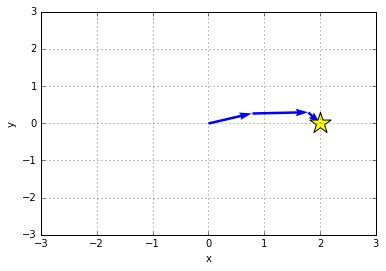

In [35]:
def predict(model, x_test, plot=0):
    x_data = Variable(x_test)
    o = model(x_data)
    car = CartLayer(len(o))
    predpos = calc_car_pos(car, o)
    truepos = Variable(x_test)
    loss = loss_function(o,predpos, truepos)
    print "loss: {}bbbbb".format(loss)
    print "v,w: \n{}".format(o)
    # print car.path
    if(plot>0):
        plot_path(car.path, x_data.data[0])

sample_r     = [2]
sample_theta = [np.deg2rad(0)]# 重みの保存と読み込み
sample_x_test = generate_dataset(r,theta)
predict(model, sample_x_test, plot=1)

# 重みの保存と読み込み

In [31]:
# save
def save_pretrained(model, name):
    serializers.save_npz(name, model)

save_pretrained(model, 'tmp.model')

In [47]:
# load
def load_pretrained(name):
    load_model = Generator()
    serializers.load_npz(name, load_model)
    return load_model

load_model = load_pretrained('2019-01-29_1000data050epoch.model')

### 2018/11/27
---
* バッチで処理 →　学習回数を増やしてデータを取る
* ネットワークを変える

### 2019/01/22 オフィスアワー 

* lossを貯めて擬似的にmini-batch処理
* chainer SLAM 藤本さん qiita の記事?
* 同次変換行列ができれば...
* バッチ処理は先送りするのも検討
* 経路の途中の計算を諦めて評価値だけ天から降ってくるものとして扱う案
* NNで最適制御（普通の制御よりは複雑（非線形項））
* 前後左右の加減速（ドローンの風で安定しないなど）

### 次回までの課題
* 次元ごとにforwordして結果を比較 
  - lossの計算が怪しい

* 180度を跨がない
  - -90～90度の範囲で学習
  
* tanh (-1 ~ 1)やシグモイド(正)で無茶な加減速を抑制
  - tanh層を加えた
  - 最大速度　　:１
  - 最大角速度　:

* 学習回数を増やして結果を比較
  - 今まで1000データ 5エポック
  - 今回は1000データ 50エポック

* (できたらバッチ処理)
  - lossの

## 検証① 入力がバッチのとき・バッチでないときの結果を比較

In [51]:
sample_input = np.array([ [2,0], [0,2], [0,-2] ], dtype=np.float32)
predict(model, sample_input)
print '\n---\n'
predict(model,np.array([[2,0]], dtype=np.float32))
predict(model,np.array([[0,2]], dtype=np.float32))
predict(model,np.array([[0,-2]], dtype=np.float32))

variable([202.65436 176.29417 140.10983])
loss: variable(173.01945)
v,w: 
variable([[[ 0.82411385  0.33629492]
           [ 1.         -0.30224577]
           [ 0.37108412 -0.99999416]]

          [[ 1.          0.9999829 ]
           [-0.00540561 -1.        ]
           [-1.         -1.        ]]

          [[ 0.6634839  -0.66987   ]
           [ 1.         -0.7396703 ]
           [ 0.87590396 -0.9730202 ]]])

---

variable([3.2773476])
loss: variable(3.2773476)
v,w: 
variable([[[ 0.82411385  0.33629498]
           [ 1.         -0.30224586]
           [ 0.37108395 -0.99999416]]])
variable([39.710297])
loss: variable(39.710297)
v,w: 
variable([[[ 1.          0.9999829 ]
           [-0.00540567 -1.        ]
           [-1.         -1.        ]]])
variable([5.599857])
loss: variable(5.599857)
v,w: 
variable([[[ 0.66348386 -0.66987   ]
           [ 1.         -0.7396703 ]
           [ 0.87590396 -0.97302014]]])


# 分散

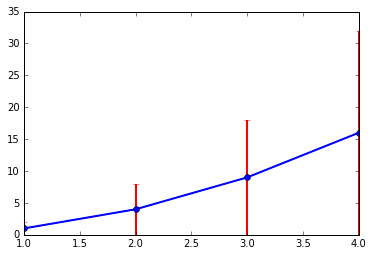

In [32]:
sample_x = [1,2,3,4]
sample_y = [1,4,9,16]
sample_error = [1,4,9,16]
def plot_error(x,y,err):
    plt.plot(x,y)
    plt.errorbar(x,y,yerr=err,ecolor='r',color='b',ls='solid',lw=2,marker='o')
    plt.show()

plot_error(sample_x,sample_y,sample_error)